### Configuration

In [2]:
IMAGE_SIZE = 256
EPOCHS = 1
NOISE_SIZE = 100
NUM_NEW_IMAGES = 1000
DATASET_FOLDER = 'Multi Cancer/Brain Cancer/brain_menin'
BATCH_SIZE = 64
LR_D = 0.0002 
LR_G = 0.0002 

BETA1 = 0.9 
EPSILON = 0.001 
LEAK_RELU_APLPHA = 0.2 

KERNEL_INITIALIZER='glorot_uniform' 

### Imports

In [3]:
from datetime import datetime
import os
from glob import glob
from IPython import display
import kagglehub
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from PIL import Image
import pytz
import random
from numpy import ndarray
import skimage as sk
from skimage import io
from skimage import util
from skimage import transform
import tensorflow as tf
from keras import layers
import time

2024-12-21 21:19:29.413826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 21:19:29.420399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 21:19:29.428326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 21:19:29.430702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 21:19:29.436888: I tensorflow/core/platform/cpu_feature_guar

### Load dataset

In [4]:
# download dataset from kaggle
#path = kagglehub.dataset_download("obulisainaren/multi-cancer")
#print("Path to dataset files:", path)

In [5]:
#images normalization

def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, [256, 256])     
    image = (image-127.5)/127.5                  
    return image

#load dataset from folder 

def load_dataset(folder_path, batch_size, limit = 2500):

    all_image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    random.shuffle(all_image_paths)
    selected_paths = all_image_paths[:limit]

    dataset = tf.data.Dataset.from_tensor_slices(selected_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  
    dataset = dataset.shuffle(buffer_size=2500)  
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)  
    return dataset

#show images from dataset

def show_samples(sample_images):
    print(f"Displaying {len(sample_images)} images.")

    figure, axes = plt.subplots(1, len(sample_images), figsize=(5 * len(sample_images), 5))

    if len(sample_images) == 1:
        axes = [axes] 

    for index, axis in enumerate(axes):
        axis.axis('off') 
        image_array = sample_images[index]  
        axis.imshow((image_array + 1) / 2)  

    plt.show()
    plt.close()


### Brain tumor images from kaggle

I0000 00:00:1734787170.241823 1732294 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734787170.264329 1732294 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734787170.264437 1732294 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734787170.265701 1732294 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Displaying 5 images.


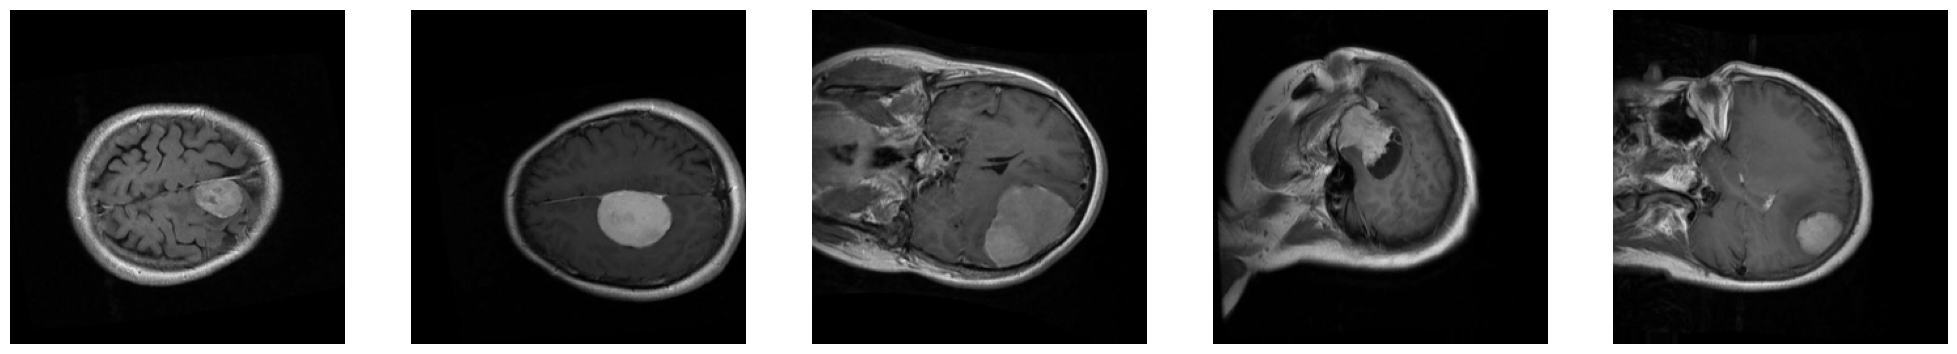

In [6]:
# Create the dataset
BATCH_SIZE = 64
dataset = load_dataset(DATASET_FOLDER, BATCH_SIZE)

for sample_images in dataset.take(1): 
    sample_images = sample_images.numpy()  
    break 

sample_images = sample_images[:5]
show_samples(sample_images)

# Models


### Generator

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Input noise vector
    model.add(layers.Input(shape=(NOISE_SIZE,)))
    
    #first layer start with 16x16x512
    model.add(layers.Dense(16 * 16 * 512, use_bias=False))  
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((16, 16, 512)))
    assert model.output_shape == (None, 16, 16, 512)  

    # second layers upsample to 32x32
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())

    # third layers upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())
    
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.ReLU())
    

    # fifth layers upsample to 128x128
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh',
                                     kernel_initializer=KERNEL_INITIALIZER))
    assert model.output_shape == (None, 256, 256, 3)

    return model

generator = make_generator_model()

# try to generate image by untrained generator 
noise = tf.random.normal([1, NOISE_SIZE])
generated_image = generator(noise, training=False)

generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype('uint8'))

2024-12-21 21:19:31.352562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1734787171.390506 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.400096 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.420739 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.421150 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.427671 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.428126 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.429662 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.430079 1732294 gpu_

###  Discriminator

In [8]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(256, 256, 3)))
    
    # first layer with images pixel    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    kernel_initializer=KERNEL_INITIALIZER))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU(negative_slope=LEAK_RELU_APLPHA))
    model.add(layers.Dropout(0.3))
    
    
    # second layer 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                    kernel_initializer=KERNEL_INITIALIZER))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU(negative_slope=LEAK_RELU_APLPHA))
    model.add(layers.Dropout(0.3))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
#Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
#The model will be trained to output positive values for real images, and negative values for fake images.
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00030072]], shape=(1, 1), dtype=float32)


W0000 00:00:1734787171.566894 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.568341 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.568569 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.568802 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.569183 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.569820 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.570692 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.576220 1732294 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734787171.576468 1732294 gp

## Loss and optimizers

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers
The discriminator and the generator optimizers are different since we will train two networks separately.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_G, beta_1=BETA1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_D, beta_1=BETA1)

### Visualized each epoch loss

In [13]:
def summarize_epoch(epoch, d_losses, g_losses, save_image=True):
  
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    if save_image:
        plt.savefig("losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    

# Training


### Save checkpoints

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Save images 

In [15]:
def generate_and_save_images(model, epoch, test_input, save_image=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      generated_image2 = predictions[i].numpy() * 127.5 + 127.5
      plt.imshow(generated_image2.astype('uint8'))

      plt.axis('off')

  if save_image:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch ))
  plt.show()

#### Noise sample array for generating images

In [16]:
noise_dim = NOISE_SIZE
num_examples_to_generate = 16

#set seed for normal distribution and let noise be the same
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

## Training step

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [18]:
tz_Taipei = pytz.timezone('Asia/Taipei')

def train(dataset, epochs):
  print('Training started at: ', datetime.now(tz_Taipei))
  save_image = False
  
  d_losses = []
  g_losses = []


  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      
      d_loss, g_loss = train_step(image_batch)
      d_losses.append(d_loss)
      g_losses.append(g_loss)

    # Produce images 
    display.clear_output(wait=True)
    

    # Save the model every 100 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      save_image = True

    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             save_image)
    summarize_epoch(epoch, d_losses, g_losses, save_image)
    save_image = False
    print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  summarize_epoch(epoch, d_losses, g_losses)

  

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

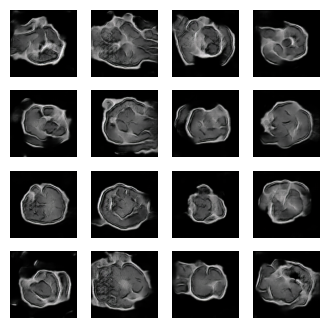

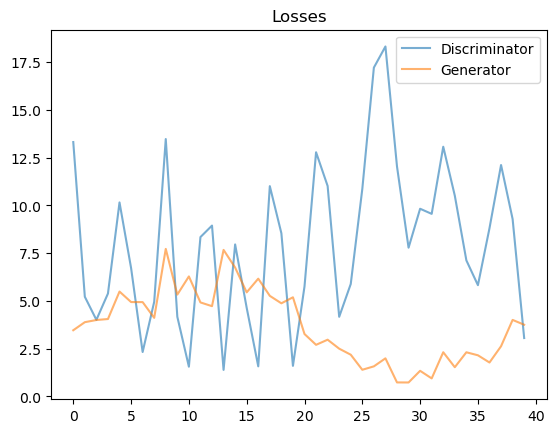

In [36]:
train(dataset, EPOCHS)

### Restore checkpoint 
To restore a checkpoint upload a the ckpt files into training_checkpoints folder.

In [35]:
# upload the files (checkpoint, ckpt-xxx.index, ckpt-xxx.data-*) into training_checkpoints folder
RESTORE_CHECKPOINT = True
if RESTORE_CHECKPOINT:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Display generated images

Displaying 5 images.


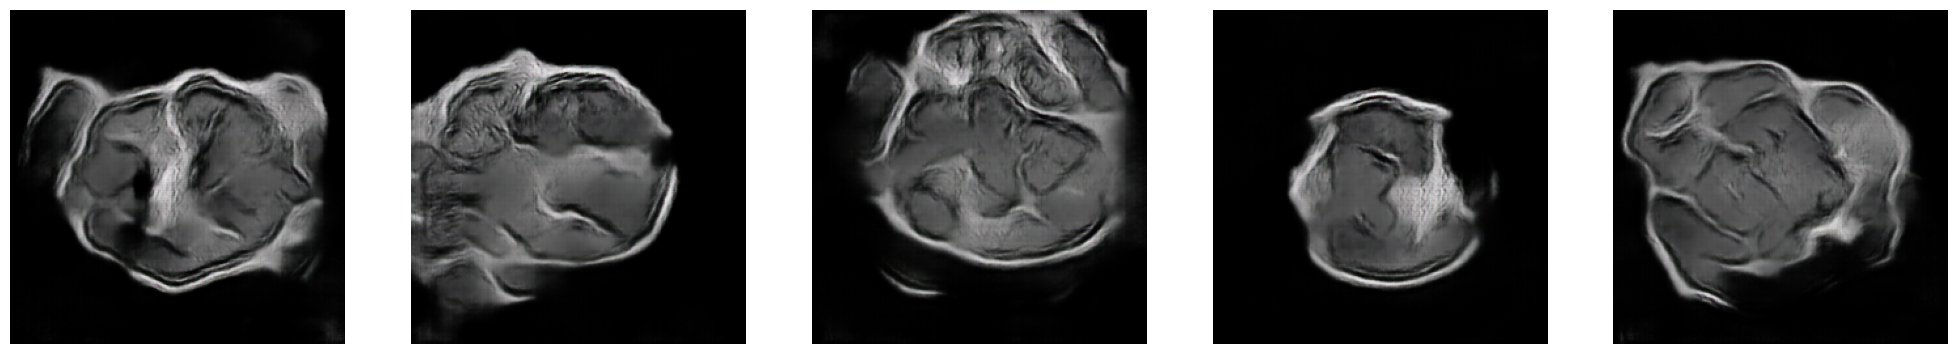

In [37]:
noise = tf.random.normal([5, NOISE_SIZE])
generated_image = generator(noise, training=False)
show_samples(generated_image)

# Create a GIF


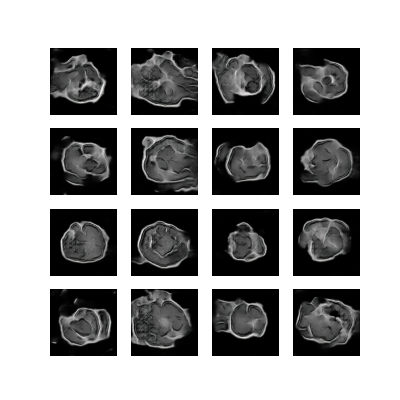

In [38]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

### Create an animated gif using the images saved during training.

In [23]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 5*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

/tmp/ipykernel_1732294/3280211592.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_1732294/3280211592.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
